In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

1.提取并清洗数据

In [4]:
base_path='data/电商用户数据.xlsx'
def read_data(file_name):
    df=pd.read_excel(file_name)
    df_cleaned = df.drop_duplicates(subset=['买家昵称', '付款日期', '订单状态'], keep='first')
    df_cleaned = df_cleaned.dropna(subset=['城市'])
    return df_cleaned

In [5]:
df_cleaned=read_data(base_path)

2.EDA探索性数据分析

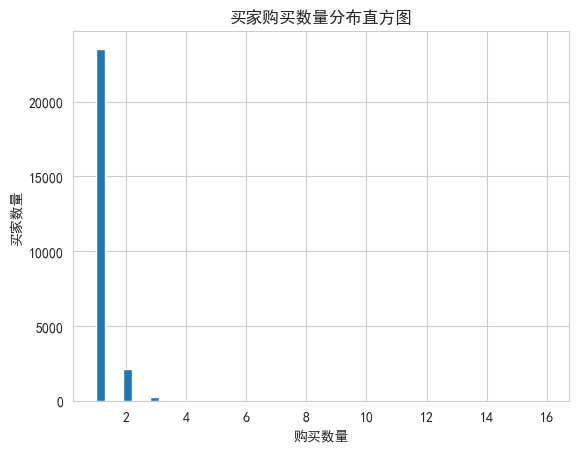

In [6]:
df_cleaned.groupby('买家昵称')['购买数量'].count ().plot(kind='hist',bins=50)
plt.xlabel('购买数量')
plt.ylabel('买家数量')
plt.title('买家购买数量分布直方图')
plt.show()

用户倾向于单件即时消费特征,几乎无凑单行为

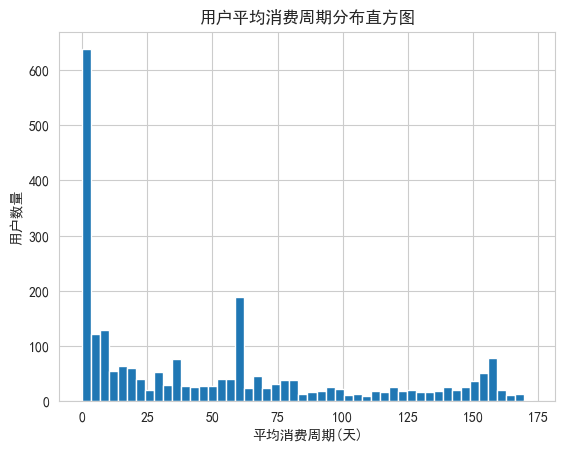

平均消费周期的平均值: 50.00 天
平均消费周期的中位数: 35.00 天


In [7]:
# 计算每个用户的平均消费周期
def calculate_avg_purchase_cycle(df):
    df_sorted = df.sort_values(['买家昵称', '付款日期'])
    # 计算每个用户相邻购买之间的时间间隔
    df_sorted['时间间隔'] = df_sorted.groupby('买家昵称')['付款日期'].diff()
    # 计算每个用户的平均消费周期
    avg_cycle = df_sorted.groupby('买家昵称')['时间间隔'].mean()
    return avg_cycle
user_avg_cycle = calculate_avg_purchase_cycle(df_cleaned)
user_avg_cycle.dt.days.plot(kind='hist', bins=50)
plt.xlabel('平均消费周期(天)')
plt.ylabel('用户数量')
plt.title('用户平均消费周期分布直方图')
plt.show()
print(f"平均消费周期的平均值: {user_avg_cycle.mean().days:.2f} 天")
print(f"平均消费周期的中位数: {user_avg_cycle.median().days:.2f} 天")


大多数用户的平均消费周期集中在 0~25天 的区间内，其中在 0天 左右的用户数量最多（超过600人），表明有大量用户具有非常短的消费周期，可能为频繁购买或复购用户。

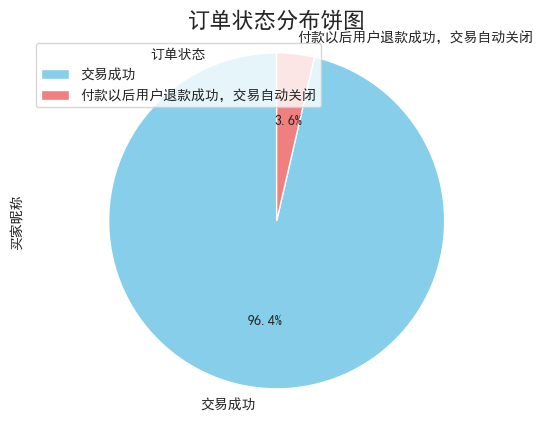

In [8]:
df_cleaned.groupby('订单状态')['买家昵称'].count().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    colors=['skyblue', 'lightcoral']
)
plt.title('订单状态分布饼图', fontsize=16)
plt.legend(title='订单状态', loc='upper left')  # 或者去掉这一行，只用默认标签
plt.axis('equal')
plt.show()

订单交易状态良好

In [9]:
df_cleaned['实付金额'].mean ()

np.float64(126.24818507068672)

In [10]:
bins=[0,25,50,100,200,300,500]

(array([   0., 4755., 8728., 9893., 5381.,   27.]),
 array([  0.,  25.,  50., 100., 200., 300., 500.]),
 <BarContainer object of 6 artists>)

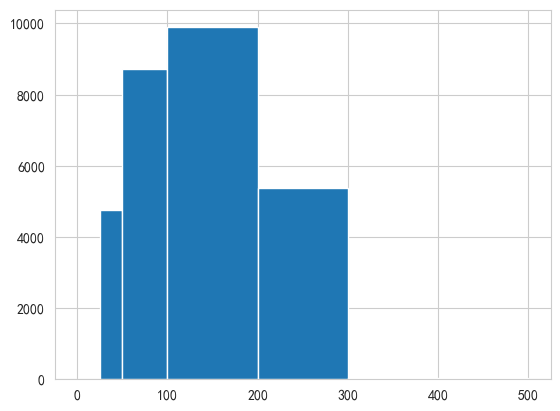

In [11]:
plt.hist(df_cleaned['实付金额'],bins=bins)

小额消费为主,平均消费为120,应选择薄利多销的策略

<Axes: xlabel='城市'>

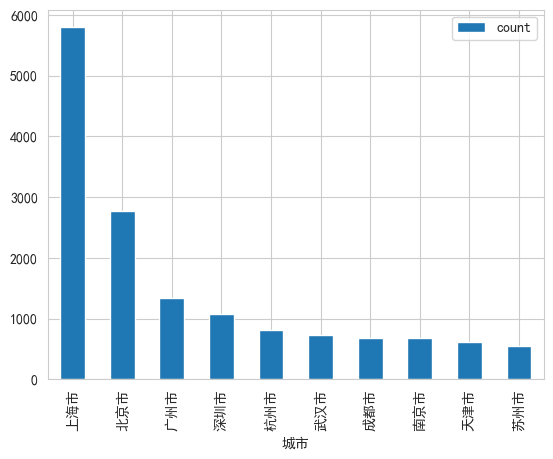

In [12]:
df_cleaned['城市'].value_counts().reset_index().iloc[:10].plot(x='城市',y='count',kind='bar')

消费地区主力多为沿海地区,符合中国经济分布

3.构造用户画像

In [13]:
def build_user_picture():
    data=df_cleaned[['买家昵称','付款日期','实付金额','购买数量']]
    lastest=(data.sort_values(['买家昵称','付款日期'], ascending=[True, False]).drop_duplicates(subset=['买家昵称'],keep='first').reset_index(drop=True))
    now=pd.to_datetime('2019-7-1')
    lastest['difftime']=(now-lastest['付款日期']).dt.days
    lastest=lastest[['买家昵称','difftime']]
    data=pd.merge(data,lastest,on='买家昵称',how='left')
    data.rename(columns={'difftime':'R'},inplace=True)
    data_f = data.groupby('买家昵称')['购买数量'].count().reset_index()
    data_f.rename(columns={'购买数量': 'F'}, inplace=True)
    data_m = data.groupby('买家昵称')['实付金额'].sum().reset_index()
    data_m.rename(columns={'实付金额': 'M'}, inplace=True)
    data = pd.merge(data, data_f, on='买家昵称', how='left')
    data = pd.merge(data, data_m, on='买家昵称', how='left')
    return  data


In [14]:
data = build_user_picture()

In [15]:
rfm = data[['买家昵称', 'R', 'F', 'M']].drop_duplicates().reset_index(drop=True)
rfm['R_score'] = pd.qcut(rfm['R'].rank(method='first'), 5, labels=[5, 4, 3, 2, 1])
rfm['F_score'] = pd.qcut(rfm['F'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_score'] = pd.qcut(rfm['M'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])

In [16]:
rfm

,买家昵称,R,F,M,R_score,F_score,M_score
0,叫我李2,180,1,186,1,1,4
1,0cyb1992,180,1,145,1,1,3
2,萝污萌莉,180,1,194,1,1,4
3,atblovemyy,180,1,84,1,1,2
4,小星期鱼,170,2,146,1,5,3
...,...,...,...,...,...,...,...
25943,2松松贝贝0,0,1,69,5,5,2
25944,2ganlin7,0,1,216,5,5,5
25945,点大a,0,1,231,5,5,5
25946,8陈爷558989,0,1,99,5,5,3


In [17]:
r_avg = rfm['R_score'].astype(float).mean()
f_avg = rfm['F_score'].astype(float).mean()
m_avg = rfm['M_score'].astype(float).mean()

In [18]:
def get_rfm_label(r,f,m,r_avg,f_avg,m_avg):
    if r >= r_avg and f >= f_avg and m >= m_avg:
        return '重要价值客户'
    elif r<r_avg and f >= f_avg and m >= m_avg:
        return '重要保持客户'
    elif r >= r_avg and f<f_avg and m >= m_avg:
        return '重要发展客户'
    elif r >= r_avg and f >= f_avg and m < m_avg:
        return '一般价值客户'
    elif r < r_avg and f < f_avg and m >= m_avg:
        return '重要挽留客户'
    elif r < r_avg and f >= f_avg and m < m_avg:
        return '一般保持客户'
    elif r >= r_avg and f < f_avg and m < m_avg:
        return '新客户'
    elif r < r_avg and f < f_avg and m < m_avg:
        return '流失客户'

In [19]:
rfm['label'] = rfm.apply(lambda row: get_rfm_label(row['R_score'], row['F_score'], row['M_score'], r_avg, f_avg, m_avg), axis=1)

In [20]:
rfm

,买家昵称,R,F,M,R_score,F_score,M_score,label
0,叫我李2,180,1,186,1,1,4,重要挽留客户
1,0cyb1992,180,1,145,1,1,3,重要挽留客户
2,萝污萌莉,180,1,194,1,1,4,重要挽留客户
3,atblovemyy,180,1,84,1,1,2,流失客户
4,小星期鱼,170,2,146,1,5,3,重要保持客户
...,...,...,...,...,...,...,...,...
25943,2松松贝贝0,0,1,69,5,5,2,一般价值客户
25944,2ganlin7,0,1,216,5,5,5,重要价值客户
25945,点大a,0,1,231,5,5,5,重要价值客户
25946,8陈爷558989,0,1,99,5,5,3,重要价值客户


使用聚类算法构造用户画像

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [22]:
rfm_features = rfm[['R', 'F', 'M']]
scaler = StandardScaler()
rfm_features_scaled = scaler.fit_transform(rfm_features)
rfm_features_scaled=pd.DataFrame(rfm_features_scaled, columns=rfm_features.columns)

In [37]:
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=1)
    kmeans.fit(rfm_features_scaled)
    inertia.append(kmeans.inertia_)

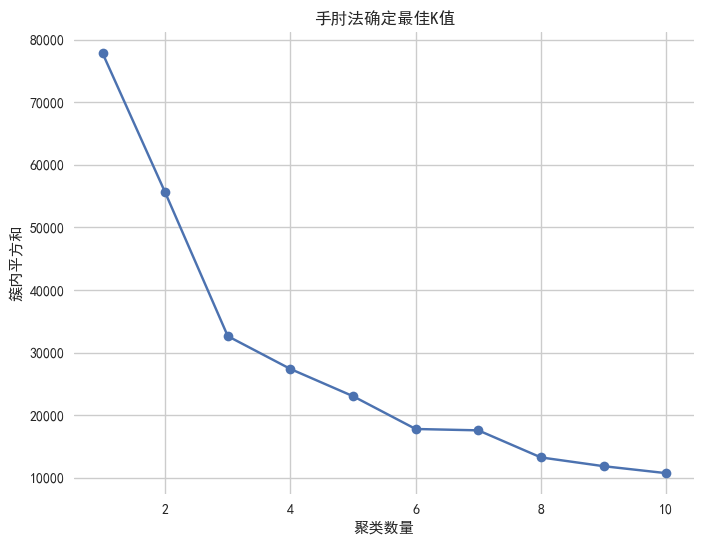

In [36]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(8,6))
plt.plot(k_range,inertia,marker='o')
plt.xlabel('聚类数量')
plt.ylabel('簇内平方和')
plt.title('手肘法确定最佳K值')
plt.show()

In [25]:
best_k=4
kmeans=KMeans(n_clusters=best_k, random_state=42, n_init=1)
kmeans.fit(rfm_features_scaled)
rfm['cluster']=kmeans.labels_

In [26]:
rfm

,买家昵称,R,F,M,R_score,F_score,M_score,label,cluster
0,叫我李2,180,1,186,1,1,4,重要挽留客户,3
1,0cyb1992,180,1,145,1,1,3,重要挽留客户,0
2,萝污萌莉,180,1,194,1,1,4,重要挽留客户,3
3,atblovemyy,180,1,84,1,1,2,流失客户,0
4,小星期鱼,170,2,146,1,5,3,重要保持客户,2
...,...,...,...,...,...,...,...,...,...
25943,2松松贝贝0,0,1,69,5,5,2,一般价值客户,1
25944,2ganlin7,0,1,216,5,5,5,重要价值客户,1
25945,点大a,0,1,231,5,5,5,重要价值客户,1
25946,8陈爷558989,0,1,99,5,5,3,重要价值客户,1


In [27]:
cluster_centers = rfm.groupby('cluster')[['R', 'F', 'M']].mean().reset_index()

In [28]:
cluster_centers

,cluster,R,F,M
0,0,147.298132,1.000120,77.100814
1,1,33.859189,1.000000,122.698435
2,2,73.073952,2.166804,272.512325
3,3,130.883174,1.000000,199.426060


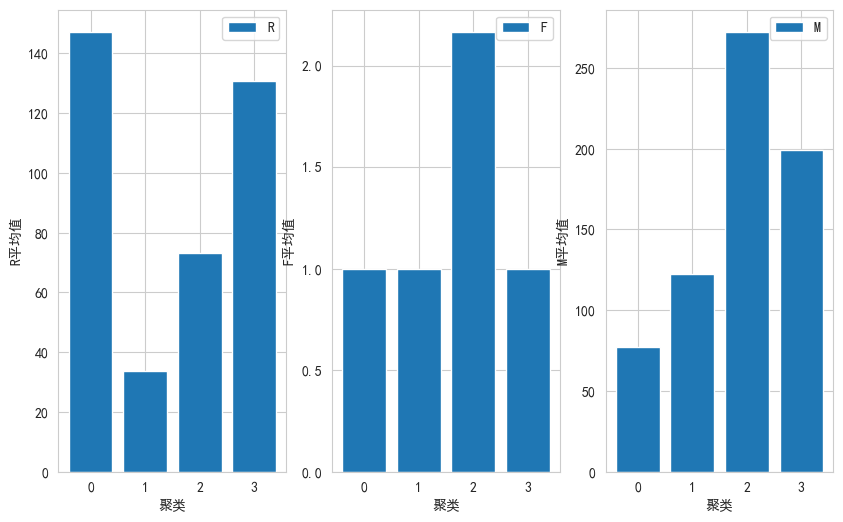

In [29]:
plt.figure(figsize=(10,6))
count=1
for column in cluster_centers.columns[1:]:
    plt.subplot(1,3,count)
    plt.bar(x=cluster_centers['cluster'], height=cluster_centers[column], label=column)
    count+=1
    plt.xlabel('聚类')
    plt.ylabel('{}平均值'.format( column))
    plt.legend()
plt.show()


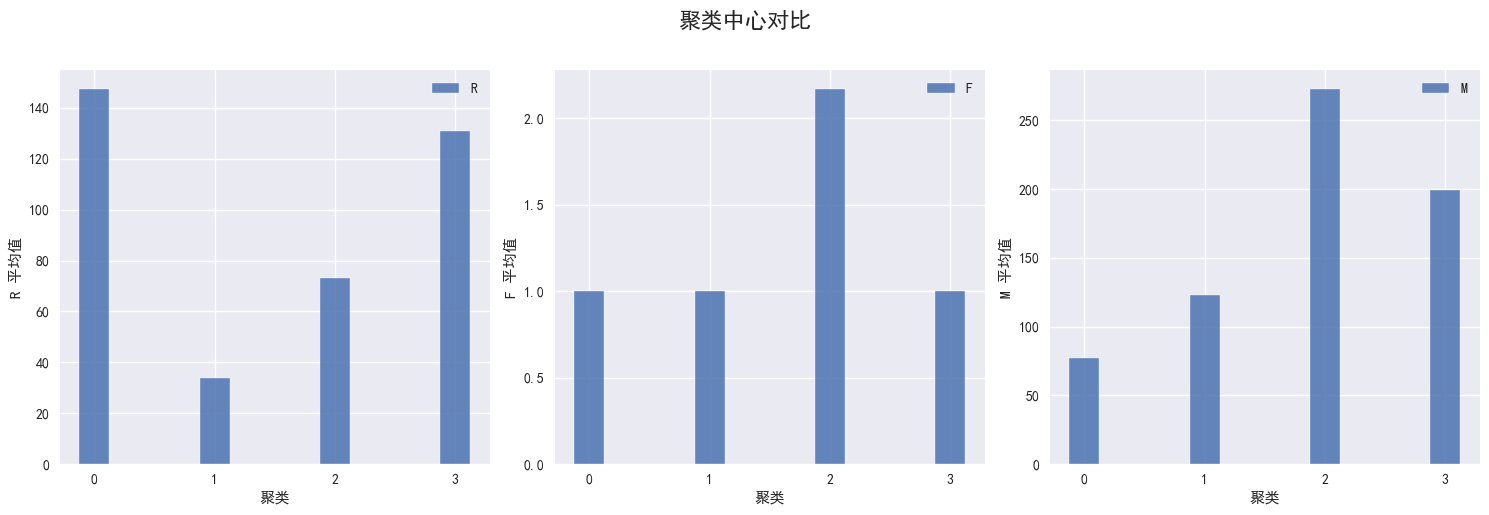

In [30]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8')
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False# 白板风格，好看
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
fig.suptitle('聚类中心对比', fontsize=16, y=1.02)

x = np.arange(cluster_centers.shape[0])       # 0 1 2 … n_cluster-1
width = 0.25                                  # 柱宽

for ax, col in zip(axes, cluster_centers.columns[1:]):
    ax.bar(x, cluster_centers[col], width, label=col, alpha=0.85)
    ax.set_xticks(x)
    ax.set_xticklabels(cluster_centers['cluster'])
    ax.set_xlabel('聚类')
    ax.set_ylabel(f'{col} 平均值')
    ax.legend(frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


聚类客户0:
    R值高(超过140),F值低(越1次),M值低(约为110),他们很久没有消费,为流失客户
聚类客户1:
    R值最低,说明最近消费过,F值低(越1次),M值中位数(约为120),他们最近消费过,但最近消费的次数少,为潜力新客户
聚类客户2:
    R值中位数(约为55),F值最高(超过3次),M值最高(接近500),他们消费次数高,消费多,且有最近消费过,为重要价值客户
聚类客户3:
    R值第二高,F值第二高,M值第二高,各项水平都为中间水平,  他们是未来的重点客户,为重要保持客户


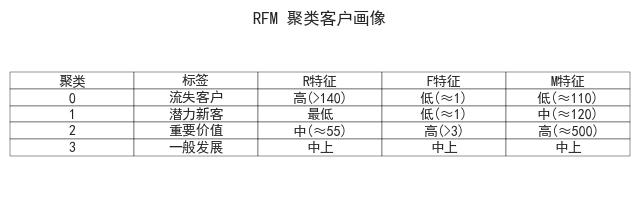

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
        '聚类': [0,1,2,3],
        '标签': ['流失客户','潜力新客','重要价值','一般发展'],
        'R特征': ['高(>140)','最低','中(≈55)','中上'],
        'F特征': ['低(≈1)','低(≈1)','高(>3)','中上'],
        'M特征': ['低(≈110)','中(≈120)','高(≈500)','中上']
})

# 把表格直接画成“可视化卡片”，再也不用对齐空格
fig, ax = plt.subplots(1,1, figsize=(8,2))
ax.axis('off')
table = ax.table(cellText=df.values,
                 colLabels=df.columns,
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
plt.title('RFM 聚类客户画像', pad=10)
plt.show()


In [32]:
rfm['聚类标签']=rfm['cluster'].apply(lambda x: '流失客户' if x==0 else '潜力新科' if x==1 else '重要价值' if x==2 else '一般发展')

In [33]:
rfm

,买家昵称,R,F,M,R_score,F_score,M_score,label,cluster,聚类标签
0,叫我李2,180,1,186,1,1,4,重要挽留客户,3,一般发展
1,0cyb1992,180,1,145,1,1,3,重要挽留客户,0,流失客户
2,萝污萌莉,180,1,194,1,1,4,重要挽留客户,3,一般发展
3,atblovemyy,180,1,84,1,1,2,流失客户,0,流失客户
4,小星期鱼,170,2,146,1,5,3,重要保持客户,2,重要价值
...,...,...,...,...,...,...,...,...,...,...
25943,2松松贝贝0,0,1,69,5,5,2,一般价值客户,1,潜力新科
25944,2ganlin7,0,1,216,5,5,5,重要价值客户,1,潜力新科
25945,点大a,0,1,231,5,5,5,重要价值客户,1,潜力新科
25946,8陈爷558989,0,1,99,5,5,3,重要价值客户,1,潜力新科


## 营销策略   <!-- 标题前后各留 1 空行 -->

### 1. 流失客户
- 召回邮件 + 回归优惠券（“我们想念你”）
- 券面额：￥20，有效期 3 天

### 2. 潜力新客
- 限时优惠券 ￥15，促二次下单
- 新人引导 & 产品教程邮件

### 3. 一般发展客户
- 产品升级优惠券 ￥30
- 基于历史订单的相似推荐

### 4. 重要价值客户
- VIP 专属优惠券 ￥50
- 全年包邮 + 专属客服